Apply guided backprop on own model

In [5]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model 
import wandb
input_path = "C:/DL_Lab/Racoon_dataset/train/raccoon-20_jpg.rf.fb19aa368c074a61eed8829617ed6b7c.jpg"

(-0.5, 223.5, 223.5, -0.5)

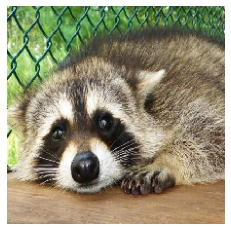

In [6]:
# load and import image with keras in RGB format
orig_image = load_img(input_path, target_size=(224,224))
image = img_to_array(orig_image) # scales to 0-255
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)
plt.imshow(orig_image)
plt.axis("off")

In [7]:
@tf.custom_gradient
def guided_RELU(x):
    # forward pass
    y = tf.nn.relu(x)
    # custom gradient: 
    def grad(dy):
        # is gradient > 0?
        grad_mask = tf.cast(dy > 0,"float32")
        # is fwd pass activation > 0
        act_mask = tf.cast(x > 0, "float32")
        return grad_mask * act_mask * dy
    return y, grad

In [8]:
model = wandb.restore('model.h5', run_path="stuttgartteam8/diabetic_retinopathy/24pjr9oi")
model = tf.keras.models.load_model('model.h5')


# pretrained model
#model = ResNet50(include_top=False, weights="imagenet")
#model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
model.summary()

Model: "multi_class_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)         

In [9]:
"PROBLEM: Need to get the last CNN layer for gradient > how to access it within a pretrained VGG16?"
#model.get_layer('vgg16').get_layer('block5_conv3').output
#gb_model = Model(inputs = model.inputs, outputs = model.get_layer('vgg16').get_layer('block5_conv3').output)

gb_model = Model(inputs = [model.inputs], outputs = [model.get_layer('vgg16').get_layer('block5_conv3').output])

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "block1_conv1". The following previous layers were accessed without issue: []

In [ ]:
# go through all layers and replace relu with guided_relu
for layer in model.layers:
    if hasattr(layer, "activation"):
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guided_RELU

# get access to individual gradients
with tf.GradientTape() as tape:
  inputs = tf.cast(image, tf.float32)
  # ensures that tensor is being traced by this tape
  tape.watch(inputs)
  outputs = model(inputs)
# derive outputs by inputs
grads = tape.gradient(outputs, inputs)[0]

# scale to [0,1]
min = tf.math.reduce_min(grads)
max = tf.math.reduce_max(grads)
grads = (grads - min) / (max - min)
plt.imshow(grads)

TypeError: 'NoneType' object is not subscriptable